# Supervised graph classification example

This notebook demonstrates how to train a graph classification model in a supervised setting using graph convolutional layers followed by a mean pooling layer as well as any number of fully connected layers.

The graph convolutional classification model architecture is based on the one proposed in [1] using the graph convolutional layers from [2]. This demo differs from [1] in that the dataset, MUTAG, is a collection of graphs representing chemical compounds. 

In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import stellargraph as sg
from stellargraph.mapper import GraphGenerator
from stellargraph.layer import GraphClassification
from stellargraph import StellarGraph

from stellargraph import datasets
from stellargraph.utils import plot_history

from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.manifold import TSNE
from IPython.display import display, HTML

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras import Model

## Import the data

In [2]:
dataset = datasets.MUTAG()
display(HTML(dataset.description))
graphs, graph_labels = dataset.load()

Split the data into train and test sets

In [3]:
np.sum(graph_labels == "1"), np.sum(graph_labels == "-1")

(125, 63)

In [4]:
graph_labels = pd.get_dummies(graph_labels)

In [5]:
train_graphs, test_graphs = model_selection.train_test_split(
    graph_labels, train_size=0.8, test_size=None, stratify=graph_labels
)
val_graphs, train_graphs = model_selection.train_test_split(
    train_graphs, train_size=0.4, test_size=None, stratify=train_graphs
)

In [6]:
len(train_graphs), len(val_graphs), len(test_graphs)

(90, 60, 38)

In [7]:
np.sum(train_graphs["1"]) / len(train_graphs), np.sum(val_graphs["1"]) / len(
    val_graphs
), np.sum(test_graphs["1"]) / len(test_graphs)

(0.6666666666666666, 0.6666666666666666, 0.6578947368421053)

In [8]:
train_graphs

label,-1,1
16,0,1
188,1,0
169,0,1
173,0,1
166,0,1
...,...,...
15,0,1
59,0,1
3,1,0
33,0,1


### Prepare graph generator

To feed data to the Keras model that we will create later, we need a generator. For supervised graph classification, we will an instance of `GraphGenerator`.

In [9]:
generator = GraphGenerator(graphs=graphs)

Next we need to create a sequence generators for each of our train, validation, and test data.

In [10]:
train_gen = generator.flow(
    list(train_graphs.index - 1), targets=train_graphs.values, batch_size=10
)
val_gen = generator.flow(
    list(val_graphs.index - 1), targets=val_graphs.values, batch_size=1
)
test_gen = generator.flow(
    list(test_graphs.index - 1), targets=test_graphs.values, batch_size=1
)

### Create the Keras graph classification model

We are now ready to create a Keras graph classification model using the `GraphClassification` class together with standard Keras models, e.g., Dense.

In [11]:
gc_model = GraphClassification(
    layer_sizes=[16, 16], activations=["relu", "relu"], generator=generator
)
x_inp, x_out = gc_model.build()
predictions = Dense(units=8, activation="relu")(x_out)
predictions = Dense(units=2, activation="softmax")(predictions)

In [12]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(optimizer=Adam(0.01), loss=categorical_crossentropy, metrics=["acc"])

### Train the model

We can now train the model using the model's `fit` method.

In [13]:
es = EarlyStopping(monitor="val_loss", min_delta=0, patience=10)

In [14]:
history = model.fit(
    train_gen,
    epochs=100,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,
    callbacks=[es],
)

  ['...']
  ['...']
Train for 9 steps, validate for 60 steps
Epoch 1/100
9/9 - 1s - loss: 0.6550 - acc: 0.6778 - val_loss: 0.6297 - val_acc: 0.6667
Epoch 2/100
9/9 - 0s - loss: 0.6184 - acc: 0.6667 - val_loss: 0.6335 - val_acc: 0.6667
Epoch 3/100
9/9 - 0s - loss: 0.6305 - acc: 0.6667 - val_loss: 0.6263 - val_acc: 0.6667
Epoch 4/100
9/9 - 0s - loss: 0.6255 - acc: 0.6667 - val_loss: 0.6216 - val_acc: 0.6667
Epoch 5/100
9/9 - 0s - loss: 0.6184 - acc: 0.6667 - val_loss: 0.6179 - val_acc: 0.6667
Epoch 6/100
9/9 - 0s - loss: 0.6111 - acc: 0.6667 - val_loss: 0.6127 - val_acc: 0.6667
Epoch 7/100
9/9 - 0s - loss: 0.6056 - acc: 0.6667 - val_loss: 0.6068 - val_acc: 0.6667
Epoch 8/100
9/9 - 0s - loss: 0.5974 - acc: 0.6667 - val_loss: 0.6011 - val_acc: 0.6667
Epoch 9/100
9/9 - 0s - loss: 0.5883 - acc: 0.6667 - val_loss: 0.5950 - val_acc: 0.6667
Epoch 10/100
9/9 - 0s - loss: 0.5789 - acc: 0.6667 - val_loss: 0.5885 - val_acc: 0.6667
Epoch 11/100
9/9 - 0s - loss: 0.5666 - acc: 0.6667 - val_loss: 0.589

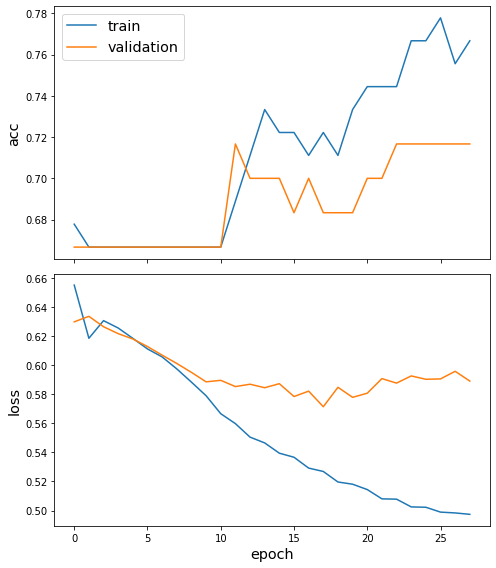

In [15]:
sg.utils.plot_history(history)

### Evaluate performance on the test graphs

In [16]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

  ['...']
38/38 [==============================] - 0s 5ms/step - loss: 0.4391 - acc: 0.7632

Test Set Metrics:
	loss: 0.4391
	acc: 0.7632
